# **East Africa drought study - model fitting**

In [1]:
source("../wwa_nonstationary_fitting.r")

# load precip data and convert to log for fitting purposes
# df <- read.csv("data/gmst-nino-chirps.csv")
df <- read.csv("data/gmst-nino-cpc.csv")
df <- cbind(df[,! colnames(df) %in% c("pr_ond", "pr_mam", "pr12", "pr24")], sapply(c("pr_ond", "pr_mam", "pr12", "pr24"), function(v) log10(df[,v]))) # ensures results match climate explorer

---
## **Linear model fits**

- Choose parameters by fitting linear model & checking significance
- Treat GMST and Nino3.4rel as independent, since Nino index is detrended

In [255]:
df <- read.csv("data/gmst-nino-chirps.csv")
df <- cbind(df[,! colnames(df) %in% c("pr_ond", "pr_mam", "pr12", "pr24")], sapply(c("pr_ond", "pr_mam", "pr12", "pr24"), function(v) log(df[,v]))) # use log10 to match climate explorer

In [256]:
rbind.fill(sapply(colnames(df)[5:ncol(df)], function(v) {
    if(grepl("mam", v)) {
        nino = "nino_mam"
    } else {
        nino = "nino_ond"
    }
    summ_gmst <- summary(lm(get(v) ~ gmst, df))
    summ_nino <- summary(lm(get(v) ~ get(nino), df))
    summ_both <- summary(lm(get(v) ~ gmst + get(nino), df))
    
    data.frame("variable" = v, 
               # "nino_cov" = nino,
               "gmst" = c(paste0(round(summ_gmst$coefficients[-1,1], 4), c("", "*")[(summ_gmst$coefficients[-1,4] < 0.05) + 1])),
               "nino" = c(paste0(round(summ_nino$coefficients[-1,1], 4), c("", "*")[(summ_nino$coefficients[-1,4] < 0.05) + 1])),
               "both" = c(paste0(round(summ_both$coefficients[-1,1], 4), c("", "*")[(summ_both$coefficients[-1,4] < 0.05) + 1], collapse = " & ")))
}, simplify = F))

variable,gmst,nino,both
<chr>,<chr>,<chr>,<chr>
pr_ond,0.3217,0.1769*,0.4744* & 0.1931*
pr_mam,-0.1385,0.0359,-0.1203 & 0.0247
pr12,0.0586,0.0898*,0.1332 & 0.0944*
pr24,0.095,0.0266,0.121 & 0.0308


---
## **New methods used in this analysis**

In [2]:
df <- read.csv("data/gmst-nino-cpc.csv")
df <- cbind(df[,! colnames(df) %in% c("pr_ond", "pr_mam", "pr12", "pr24")], sapply(c("pr_ond", "pr_mam", "pr12", "pr24"), function(v) log10(df[,v]))) # ensures results match climate explorer

# check fitted parameters against climate explorer to confirm working properly
round(fit_ns("norm", "fixeddisp", df, varnm = "pr_ond", covnm_1 = "gmst", lower = T)$par, 3)  # expect 2.114, 0.193, 0.077
round(fit_ns("norm", "shift", df, varnm = "tas_ond", covnm_1 = "gmst", lower = F)$par, 3)     # expect 25.848, 0.492, 0.990

mu0 sigma0  alpha   beta 
 2.114  0.193  0.074  0.000

mu0 sigma0  alpha   beta 
25.847  0.492  0.989  0.000

In [3]:
# also check that results match for lognormal fitting / normal fitting to log precip
df <- read.csv("data/gmst-nino-cpc.csv")
df["log_pr"] <- log(df$pr_ond)

round(fit_ns("norm", "fixeddisp", df, varnm = "log_pr", covnm_1 = "gmst", lower = T)$par, 3)
round(fit_ns("lnorm", "fixeddisp", df, varnm = "pr_ond", covnm_1 = "gmst", lower = T)$par, 3)

mu0 sigma0  alpha   beta 
 4.869  0.444  0.171  0.000

mu0 sigma0  alpha   beta 
 4.868  0.444  0.172  0.000

---
## **Bivariate analysis using ``copula`` package**

### **Test by replicating Mariam's analysis**

In [4]:
df <- read.csv("data/gmst-nino-cpc.csv")

In [5]:
# fit marginal distributions
# df["log_pr"] <- log10(df$pr_ond); mdl_pr <- fit_ns("norm", "fixeddisp", df, varnm = "log_pr", covnm_1 = "gmst", lower = T)
mdl_pr <- fit_ns("lnorm", "fixeddisp", df, varnm = "pr_ond", covnm_1 = "gmst", lower = T)
mdl_tas <- fit_ns("norm", "shift", df, varnm = "pet_ond", covnm_1 = "gmst", lower = F)

# transform marginals to U
u_pr <- map_to_u(mdl_pr, mdl_pr$x)
u_tas <- map_to_u(mdl_tas, mdl_tas$x)

# fit copula to u,v pairs
fitted_copula <- fitCopula(tCopula(), data = cbind(u_pr, u_tas), hideWarnings = T)  # warning message about using df.fixed is irrelevant: can't actually change this setting
cfit <- tCopula(coef(fitted_copula)["rho.1"], df = round(coef(fitted_copula)["df"], 0))  # has to be integer df for pCopula

In [7]:
jmodel_res(mdl_pr, mdl_tas, cfit, x = df[df$year == 2022, "pr_ond"], y = df[df$year == 2022, "pet_ond"], cov1_hist = df[df$year == 2022, "gmst"]-1.2)

,dist,fit_type,mu0,sigma0,alpha,beta,var.disp,rl_obs,rl_cf,delta_I,delta_I_rel,rp_obs,rp_cf,prob_ratio
,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<lgl>,<dbl>,<dbl>,<dbl>
pr_ond ~ gmst,lnorm,fixeddisp,4.867996,0.4436827,0.1722124,0,0.09114279,86.65775,71.98893,14.668810,FALSE,9.271601,4.824405,0.5203421
pet_ond ~ gmst,norm,shift,12.682350,0.9612213,1.6295234,0,0.96122131,14.48540,12.52997,1.955428,FALSE,2.648938,105.492926,39.8246158
joint,tCopula,stationary,NA,NA,NA,NA,0.67661490,NA,NA,NA,NA,10.956372,119.183136,10.8779746


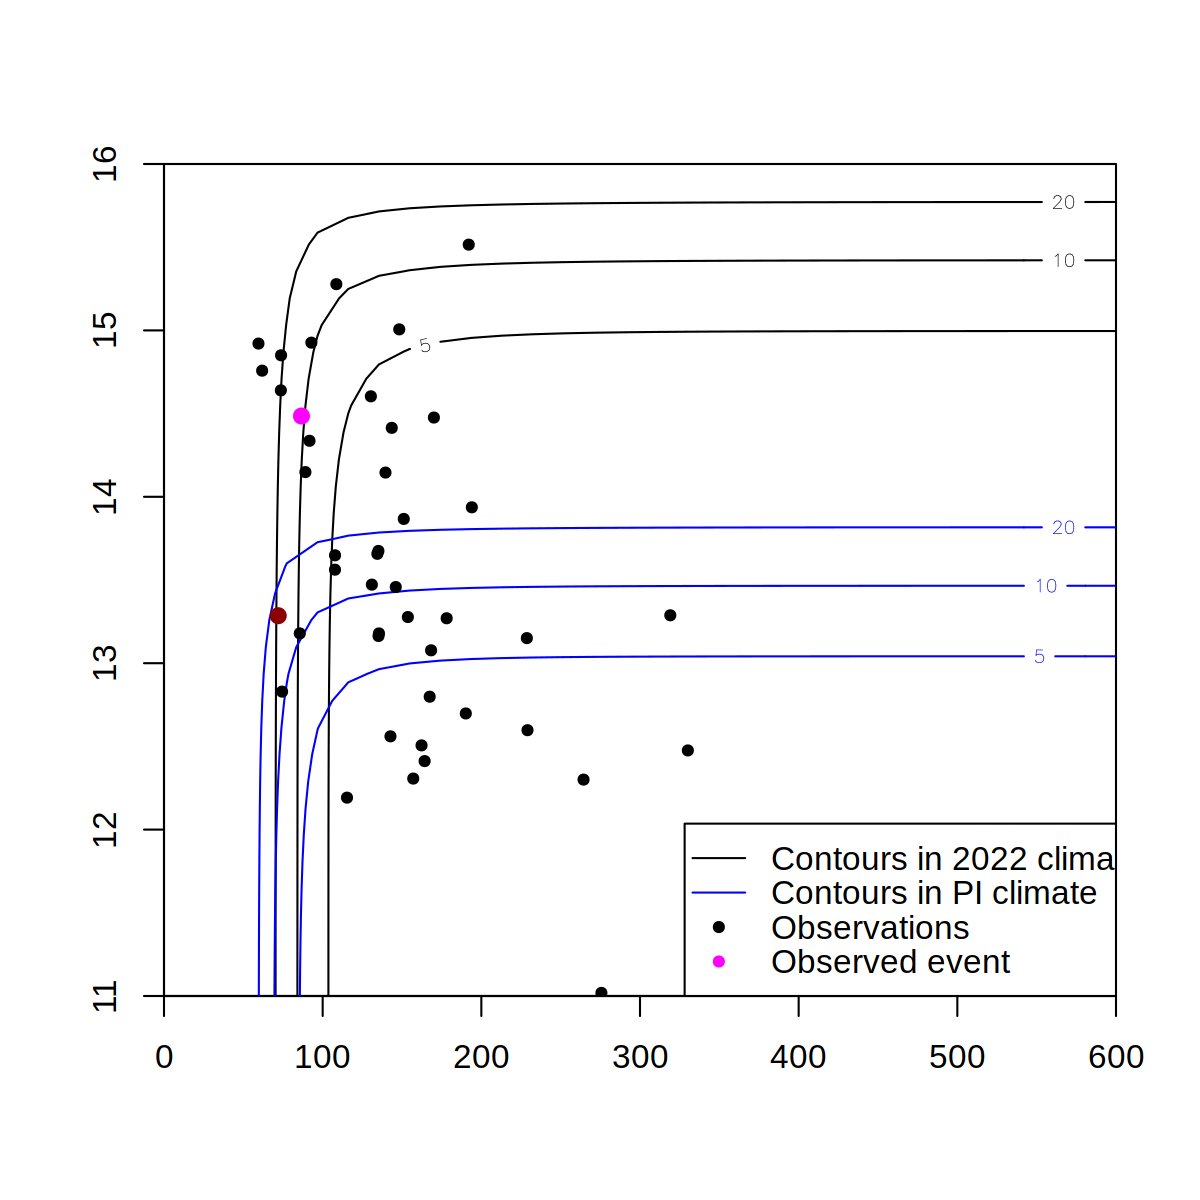

In [262]:
par(pch = 20, xaxs = "i", yaxs = "i")

contour(copula_mesh(mdl_pr, mdl_tas, cfit, df$gmst[df$year == 2022]), levels = 1/c(5,10,20), labels = c(5,10,20))
contour(copula_mesh(mdl_pr, mdl_tas, cfit, df$gmst[df$year == 2022] - 1.2), levels = 1/c(5,10,20), labels = c(5,10,20), col = "blue", add = T)
points(mdl_pr$x, mdl_tas$x, pch = 20)
points(mdl_pr$x[df$year == 2022], mdl_tas$x[df$year == 2022], pch = 20, col = "magenta", cex = 1.5)

# add event of same magnitude in historical climate
points(map_from_u(u_pr[df$year == 2022], mdl_pr, cov1 = df$gmst[df$year == 2022]-1.2),
       map_from_u(u_tas[df$year == 2022], mdl_tas, cov1 = df$gmst[df$year == 2022])-1.2, col = "darkred", cex = 1.5)

legend("bottomright", c("Contours in 2022 climate", "Contours in PI climate", "Observations", "Observed event"), col = c("black", "blue", "black", "magenta"), lty = c(1,1,NA,NA), pch = c(NA,NA,20,20))

### **Panel plot of fitted models**

- needs to be modified to work with new functions above

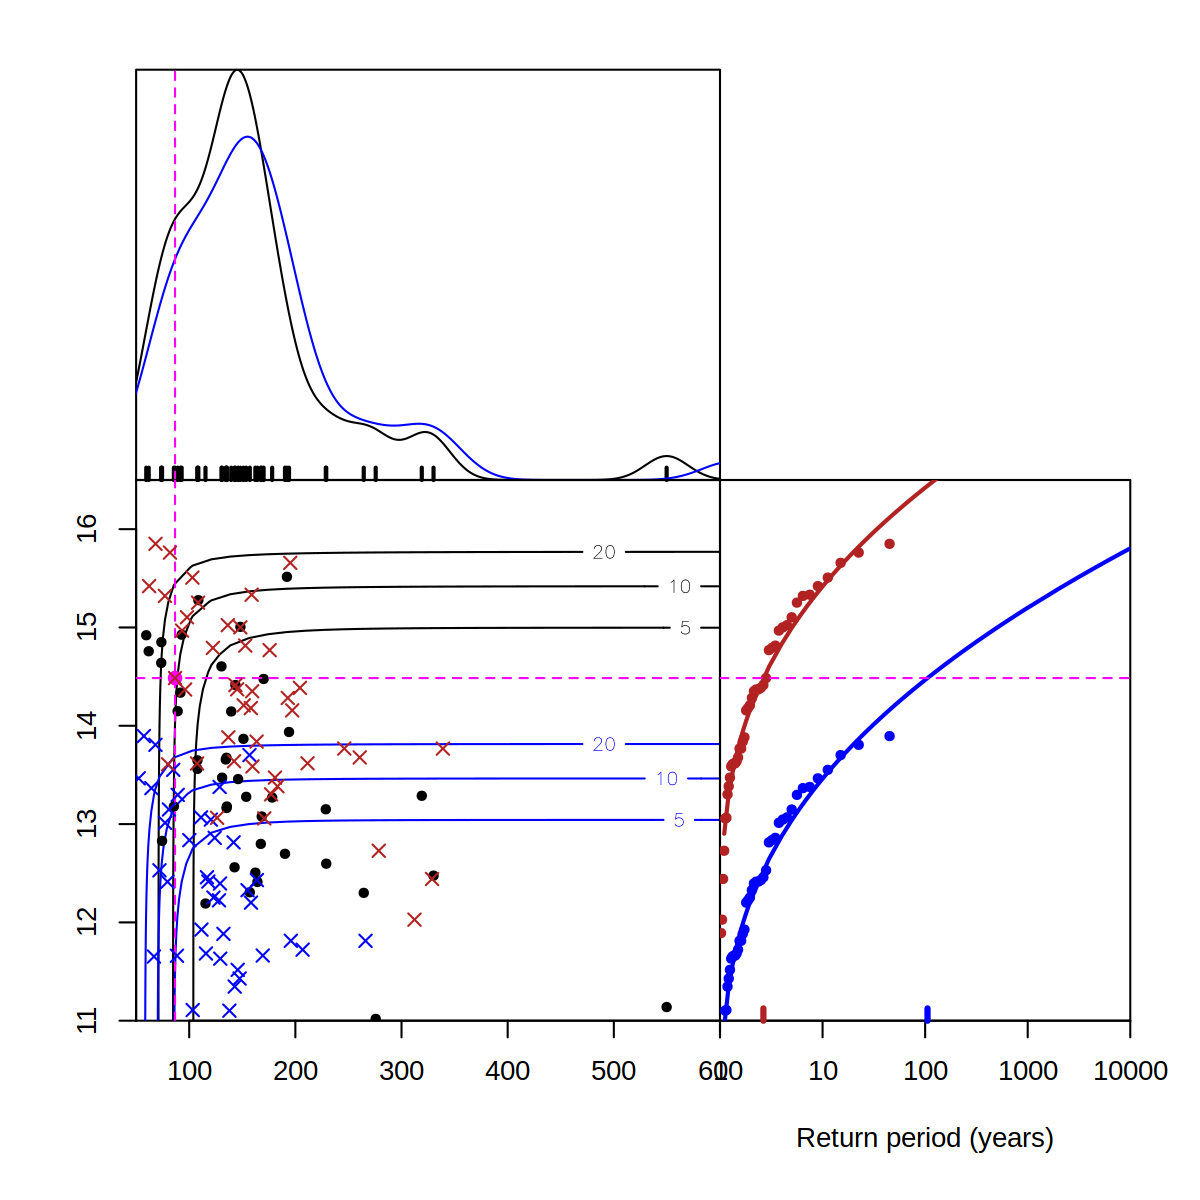

In [265]:
rc = c(1,1); w = 6; h = w; options(repr.plot.width = rc[2]*w, repr.plot.height = rc[1]*h, repr.plot.res = 200); par(mfrow = rc, pch = 20, xaxs = "i", yaxs = "i")
layout(matrix(c(1,2,3,4),2,2), widths = c(3,2), heights = c(2,3))

xrange = c(50,600)
yrange = c(11,16.5)

par(mar = c(0,4.1,2.1,0))
plot(density(mdl_pr$x), xaxt = "n", yaxt = "n", xlab = "", xlim = xrange, ylab = "", main = "", col = "black")
rug(mdl_pr$x, lwd = 2)
lines(density(map_from_u(map_to_u(mdl_pr), mdl_pr, cov1 = df$gmst[df$year == 2022])), xaxt = "n", yaxt = "n", xlab = "", xlim = xrange, ylab = "", main = "", col = "blue")
abline(v = mdl_pr$x[df$year == "2022"], col = "magenta", lty = 2)
# plot_returnperiods(mdl_pr, cov1 = df$gmst[df$year == 2022], cov2 = df$gmst[df$year == 2022] - 1.2, event_value = mdl_pr$x[df$year == 2022])

par(mar = c(5.4,4.1,0,0))
contour(copula_mesh(mdl_pr, mdl_tas, cfit, df$gmst[df$year == 2022], xrange = xrange, yrange = yrange), levels = 1/c(5,10,20), labels = c(5,10,20))
contour(copula_mesh(mdl_pr, mdl_tas, cfit, df$gmst[df$year == 2022] - 1.2, xrange = xrange, yrange = yrange), levels = 1/c(5,10,20), labels = c(5,10,20), col = "blue", add = T)
points(mdl_pr$x, mdl_tas$x, pch = 20)
points(mdl_pr$x[df$year == 2022], mdl_tas$x[df$year == 2022], pch = 20, col = "magenta", cex = 1.5)
abline(v = mdl_pr$x[df$year == 2022], h = mdl_tas$x[df$year == 2022], col = "magenta", lty = 2)

points(map_from_u(map_to_u(mdl_pr), mdl_pr, df$gmst[df$year == 2022] - 1.2), map_from_u(map_to_u(mdl_tas), mdl_tas, df$gmst[df$year == 2022] - 1.2), pch = 4, col = "blue")
points(map_from_u(map_to_u(mdl_pr), mdl_pr, df$gmst[df$year == 2022]), map_from_u(map_to_u(mdl_tas), mdl_tas, df$gmst[df$year == 2022] ), pch = 4, col = "firebrick")


plot.new()
# par(mar = c(0,0,2.1,2.1))
# contour(MASS::kde2d(map_to_u(mdl_pr), map_to_u(mdl_tas)), col = "skyblue", main = "", xaxt = "n", yaxt = "n")
# points(map_to_u(mdl_pr), map_to_u(mdl_tas), pch = 4, col = "cornflowerblue")
# contour(cfit, dCopula, add = T)

par(mar = c(5.4,0,0,2.1))
# plot.new()
# dns <- density(mdl_tas$x)
# dns_hist <- density(map_from_u(map_to_u(mdl_tas), mdl_tas, cov1 = df$gmst[df$year == 2022]))
# plot(dns$y, dns$x, yaxt = "n", xaxt = "n", xlab = "", ylim = yrange, type = "l", col = "black", xlim = range(c(dns$y, dns_hist$y)))
# rug(mdl_tas$x, side = 2, lwd = 2)
# abline(h = mdl_tas$x[df$year == "2022"], col = "magenta", lty = 2)
# lines(dns_hist$y, dns_hist$x, col = "blue")
plot_returnperiods(mdl_tas, cov1 = df$gmst[df$year == 2022], cov2 = df$gmst[df$year == 2022] - 1.2, event_value = mdl_tas$x[df$year == 2022], legend_pos = NA, yaxt = "n", ylim = yrange)

# probably better to replot with CDF on each axis? Or return level plot?

### **Fit & get results**

In [298]:
joint_model_qfit <- function(mdl_1, mdl_2, cov1_hist, cov2_hist = 0, x = NA, y = NA, dI_x_rel = F, dI_y_rel = F) {
    
    # fit copula to u,v pairs
    fitted_copula <- fitCopula(tCopula(), data = cbind(map_to_u(mdl_1), map_to_u(mdl_2)), hideWarnings = T)  # warning message about using df.fixed is irrelevant: can't actually change this setting
    cfit <- tCopula(coef(fitted_copula)["rho.1"], df = round(coef(fitted_copula)["df"], 0))  # has to be integer df for pCopula
    
    if(is.na(x)) { x <- mdl_1$x[length(mdl_1$x)]}
    if(is.na(y)) { y <- mdl_2$x[length(mdl_2$x)]}
        
    res <- jmodel_res(mdl_1, mdl_2, cfit, x = x, y = y, cov1_hist = cov1_hist, cov2_hist = cov2_hist, dI_x_rel = dI_x_rel, dI_y_rel = dI_y_rel)
    return(res)
}

In [ ]:
joint_model_qfit(fit_ns("lnorm", "fixeddisp", df, varnm = "pr_ond", covnm_1 = "gmst", lower = T), 
                 fit_ns("norm", "shift", df, varnm = "pet_ond", covnm_1 = "gmst", lower = F),
                 cov1_hist = df$gmst[df$year == 2022]-1.2, dI_x_rel = T)

,dist,fit_type,alpha,beta,var.disp,rl_obs,rl_cf,delta_I,delta_I_rel,rp_obs,rp_cf,prob_ratio
,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<lgl>,<dbl>,<dbl>,<dbl>
pr_ond ~ gmst,lnorm,fixeddisp,0.1722124,0,0.09114279,86.65775,71.98893,20.376479,TRUE,9.271601,4.824405,0.5203421
pet_ond ~ gmst,norm,shift,1.6295234,0,0.96122131,14.48540,12.52997,1.955428,FALSE,2.648938,105.492926,39.8246158
joint,tCopula,stationary,NA,NA,0.67661490,NA,NA,NA,NA,10.956372,119.183136,10.8779746


In [13]:
# w = 5; h = w; options(repr.plot.width = rc[2]*w, repr.plot.height = rc[1]*h, repr.plot.res = 200); 
mdl_1 <- fit_ns("lnorm", "fixeddisp", df, varnm = "pr_ond", covnm_1 = "gmst", covnm_2 = "nino_ond", lower = T)
mdl_2 <- fit_ns("norm", "shift", df, varnm = "tas_ond", covnm_1 = "gmst", covnm_2 = "nino_ond", lower = F)

fitted_copula <- fitCopula(tCopula(), data = cbind(map_to_u(mdl_1), map_to_u(mdl_2)), hideWarnings = T)  # warning message about using df.fixed is irrelevant: can't actually change this setting
cfit <- tCopula(coef(fitted_copula)["rho.1"], df = round(coef(fitted_copula)["df"], 0))  # has to be integer df for pCopula

event_gmst <- df$gmst[df$year == 2022]
event_nino <- df$nino_ond[df$year == 2022]

event_value_1 <- mdl_1$x[df$year == 2022]
event_value_2 <- mdl_2$x[df$year == 2022]

png(paste0("fig/joint-model_",gsub("_","-",mdl_1$varnm),"_",gsub("_","-",mdl_2$varnm), ".png"), width = 480 * 3, height = 480); {
    
    par(mfrow = c(1,3), pch = 20, xaxs = "i", yaxs = "i", cex = 1.25)
    
    plot_returnperiods(mdl_1, cov1 = event_gmst, cov2 = event_gmst - 1.2, event_value = event_value_1, legend_pos = NA, main = mdl_1$call)
    plot_returnperiods(mdl_2, cov1 = event_gmst, cov2 = event_gmst - 1.2, event_value = event_value_2, legend_pos = NA, main = mdl_2$call)
    
    contour(copula_mesh(mdl_1, mdl_2, cfit, event_gmst), levels = 1/c(5,10,20), labels = c(5,10,20), col = "red", main = "Joint exceedances")
    contour(copula_mesh(mdl_1, mdl_2, cfit, event_gmst-1.2), levels = 1/c(5,10,20), labels = c(5,10,20), col = "blue", add = T)
    
    points(mdl_1$x, mdl_2$x, pch = 20)
    points(mdl_1$x[df$year == 2022], mdl_2$x[df$year == 2022], pch = 20, col = "magenta", cex = 1.5)
}; dev.off()

jmodel_res(mdl_1, mdl_2, cfit, event_value_1, event_value_2, event_gmst - 1.2, event_nino)

png 
  2

,dist,fit_type,mu0,sigma0,alpha,beta,var.disp,rl_obs,rl_cf,delta_I,delta_I_rel,rp_obs,rp_cf,prob_ratio
,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<lgl>,<dbl>,<dbl>,<dbl>
pr_ond ~ gmst + nino_ond,lnorm,fixeddisp,4.807169,0.3835569,0.3071031,0.18346181,0.07978852,86.65775,52.67238,33.985366,FALSE,17.033852,2.351076,0.1380237
tas_ond ~ gmst + nino_ond,norm,shift,25.867992,0.4870353,0.9398281,-0.06024302,0.48703533,26.95972,25.89768,1.062046,FALSE,3.103746,242.818454,78.2339872
joint,tCopula,stationary,NA,NA,NA,NA,0.63858049,NA,NA,NA,NA,20.377937,255.680481,12.5469267


---
## **Fit marginal distributions**

In [27]:
chirps <- read.csv("data/gmst-nino-chirps.csv")
cpc <- read.csv("data/gmst-nino-cpc.csv")
centrends <- read.csv("data/gmst-nino-centrends.csv")

event_gmst <- chirps$gmst[chirps$year == 2022]
event_nino <- chirps$nino_ond[chirps$year == 2022]

event_chirps <- chirps$pr_ond[chirps$year == 2022]

In [25]:
rbind(cbind("dataset" = "centrends", model_res(fit_ns("lnorm", "fixeddisp", centrends, varnm = "pr_ond", covnm_1 = "gmst", lower = T), x = centrends$pr_ond[centrends$year == 2022],
          cov1_hist = event_gmst - 1.2, cov2_hist = event_nino)),
      cbind("dataset" = "chirps", model_res(fit_ns("lnorm", "fixeddisp", chirps, varnm = "pr_ond", covnm_1 = "gmst", lower = T), x = event_chirps,
          cov1_hist = event_gmst - 1.2, cov2_hist = event_nino)),
      cbind("dataset" = "centrends", model_res(fit_ns("lnorm", "fixeddisp", centrends, varnm = "pr_ond", covnm_1 = "gmst", covnm_2 = "nino_ond", lower = T), x = centrends$pr_ond[centrends$year == 2022],
          cov1_hist = event_gmst - 1.2, cov2_hist = event_nino)),
      cbind("dataset" = "chirps", model_res(fit_ns("lnorm", "fixeddisp", chirps, varnm = "pr_ond", covnm_1 = "gmst", covnm_2 = "nino_ond", lower = T), x = event_chirps,
          cov1_hist = event_gmst - 1.2, cov2_hist = event_nino)))

,dataset,dist,fit_type,mu0,sigma0,alpha,beta,var.disp,rl_obs,rl_cf,delta_I,delta_I_rel,rp_obs,rp_cf,prob_ratio
,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<lgl>,<dbl>,<dbl>,<dbl>
pr_ond ~ gmst,centrends,lnorm,fixeddisp,4.978569,0.3891900,0.22853426,0.00000000,0.07817307,147.0984,NA,NA,FALSE,NA,1.730259,NA
pr_ond ~ gmst1,chirps,lnorm,fixeddisp,4.961195,0.3962899,0.25429117,0.00000000,0.07987791,131.9838,98.55912,33.42464,FALSE,4.526178,2.035042,0.4496161
pr_ond ~ gmst + nino_ond,centrends,lnorm,fixeddisp,4.991322,0.6028324,0.06406238,0.14321371,0.12077609,147.0984,NA,NA,FALSE,NA,1.624891,NA
pr_ond ~ gmst + nino_ond1,chirps,lnorm,fixeddisp,4.963506,0.3967797,0.24175824,-0.02529115,0.07993940,131.9838,102.55870,29.42506,FALSE,4.390254,2.183230,0.4972900


In [24]:
cbind("dataset" = "centrends", model_res(fit_ns("lnorm", "fixeddisp", centrends, varnm = "pr_ond", covnm_1 = "gmst", lower = T), x = centrends$pr_ond[centrends$year == 2022],
          cov1_hist = event_gmst - 1.2, cov2_hist = event_nino))

,dataset,dist,fit_type,mu0,sigma0,alpha,beta,var.disp,rl_obs,rl_cf,delta_I,delta_I_rel,rp_obs,rp_cf,prob_ratio
,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<lgl>,<dbl>,<dbl>,<dbl>
pr_ond ~ gmst,centrends,lnorm,fixeddisp,4.978569,0.38919,0.2285343,0,0.07817307,147.0984,NA,NA,FALSE,NA,1.730259,NA


In [28]:
event_chirps

[1] 131.9838

In [31]:
centrends

year,gmst,nino_mam,nino_ond,pr_mam,pr_ond
<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1940,0.07666667,0.77691430,1.39961170,310.1086,109.26007
1941,0.09395833,1.18917350,0.73274440,259.6717,225.40216
1942,0.12041670,0.28281623,-1.94034330,310.4411,109.75144
1943,0.13958330,-0.77960130,-0.59956694,161.0893,82.39731
1944,0.11604170,0.27767837,-1.08851700,200.6980,181.38860
1945,0.08062500,-0.94506640,-0.93227756,170.5044,114.10845
1946,0.05145833,-0.43155667,0.15075092,170.9060,125.07189
1947,0.02625000,0.39773030,-0.74289787,321.6732,110.81993
1948,0.07666666,0.47157310,-0.75439113,181.0716,188.91757


In [30]:
chirps

year,gmst,nino_mam,nino_ond,pr_mam,pr_ond,pr12,pr24
<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1981,0.2222917,-0.35690594,-0.24403730,371.4964,117.16381,562.1121,NA
1982,0.2593750,0.62701840,2.35066650,253.5802,278.31644,605.3157,1167.4279
1983,0.2337500,1.34076010,-1.19802000,167.5513,95.95841,339.2870,944.6027
1984,0.1825000,-0.55213870,-0.89875970,139.9467,165.45930,370.6524,709.9393
1985,0.1920833,-0.72127140,-0.15817696,264.6524,108.21993,433.4701,804.1223
1986,0.1937500,-0.14711711,1.28696350,249.3618,133.42172,439.6478,873.1179
1987,0.2518750,0.94132364,0.95304096,265.8234,106.92188,437.7416,877.3894
1988,0.2910417,-0.77877350,-1.98851040,257.8672,137.43741,472.9926,910.7341
1989,0.3575000,-0.88324520,-0.20215802,243.3832,203.61742,516.4456,989.4382
